In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.stats import ortho_group
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LassoCV

In [2]:
N = 20
M = 11000 # length of time series

# Lorenz system parameters
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0

def lorenz(t, state):
    u, v, w = state
    dudt = sigma * (v - u)
    dvdt = u * (rho - w) - v
    dwdt = u * v - beta * w
    return [dudt, dvdt, dwdt]

state0 = [1.0, 1.0, 1.0]
t_span = (0, 100)
t_eval = np.linspace(t_span[0], t_span[1], M)

sol = solve_ivp(lorenz, t_span, state0, t_eval=t_eval)
t = sol.t
u, v, w = sol.y

In [3]:
np.random.seed(42)
A = 0.9 * ortho_group.rvs(N)
C = np.random.uniform(-1, 1, N); C /= np.linalg.norm(C)
x_states = np.zeros((M, N))

for i in range(1, M):
    x_states[i] = A @ x_states[i-1] + C * u.T[i] # 20x20 @ 20x1 + 20x1 * 1x1

washout, split = 1000, 7000
X_train = x_states[washout:split]
Y_train = u[washout+1:split+1]

print(f"X_train: {X_train.shape}, Y_train: {Y_train.shape}")

X_train: (6000, 20), Y_train: (6000,)


In [4]:
print('## 1. Training pure power features Lasso Regression ##')

x_train_pure = np.hstack([X_train**p for p in range(1, 5)])

scaler = StandardScaler()
X_train_pure_scaled = scaler.fit_transform(x_train_pure)
alphas_to_test = np.logspace(-6, -3, 30)

lasso_cv_pure = LassoCV(alphas=alphas_to_test, cv=5, max_iter=50000, n_jobs=-1)
lasso_cv_pure.fit(X_train_pure_scaled, Y_train)

print(f"Best Alpha: {lasso_cv_pure.alpha_}")
print(f"Sparsity: {np.sum(lasso_cv_pure.coef_ == 0)}/{lasso_cv_pure.coef_.size} zero coefficients")

## 1. Training pure power features Lasso Regression ##
Best Alpha: 0.001
Sparsity: 58/80 zero coefficients


2. Starting Closed-Loop Forecasting with Reservoir Update...
Closed-Loop MSE: 3.116491


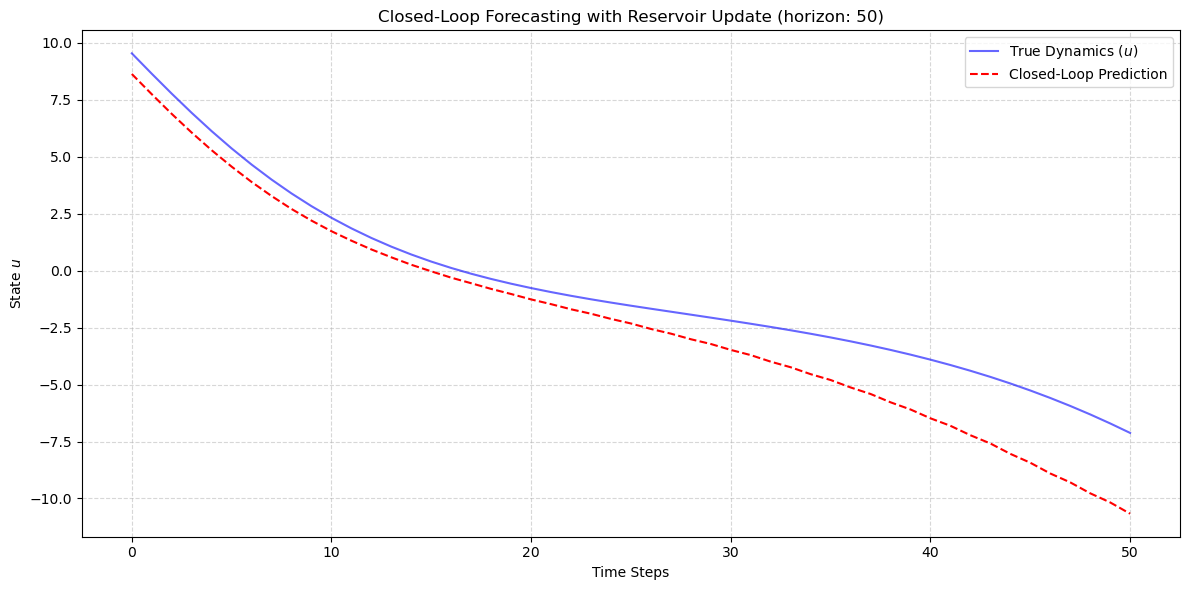

In [ ]:
print('2. Starting Closed-Loop Forecasting with Reservoir Update...')

horizon = 50  # 你想要預測多遠
x_curr = x_states[split]
x_pure = np.hstack([x_curr.reshape(1, -1)**p for p in range(1, 5)])
x_pure_scaled = scaler.transform(x_pure)

next_u = lasso_cv_pure.predict(x_pure_scaled)
predictions = []
predictions.append(next_u)

for t in range(horizon):
    u_pred = predictions[-1]
    x_next = A @ x_curr + C * u_pred

    x_next_reshaped = x_next.reshape(1, -1)
    x_pure = np.hstack([x_next_reshaped**p for p in range(1, 5)])
    x_pure_scaled = scaler.transform(x_pure)

    next_u = lasso_cv_pure.predict(x_pure_scaled)

    predictions.append(next_u)
    x_curr = x_next
    
Y_pred_pure= np.array(predictions).squeeze()

Y_test = u[split: split + len(predictions)]

mse_closed = np.mean((Y_test - Y_pred_pure)**2)
print(f"Closed-Loop MSE: {mse_closed:.6f}")

# ======================================================
# 3. Visualization
# ======================================================

plt.figure(figsize=(12, 6))

plt.plot(np.arange(len(Y_test)), Y_test, 'b-', label='True Dynamics ($u$)', alpha=0.6)
plt.plot(np.arange(len(Y_pred_pure)), Y_pred_pure, 'r--', label='Closed-Loop Prediction', linewidth=1.5)

plt.title(f"Closed-Loop Forecasting with Reservoir Update (horizon: {horizon})")
plt.xlabel("Time Steps")
plt.ylabel("State $u$")
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('../images/closed_loop_pure_forecast.png', dpi=300)

In [6]:
print('2. Training full polynomial (Multi-Task)...')

poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_full = poly.fit_transform(X_train)
alphas_to_test = np.logspace(-5, -2, 20) 

lasso_cv_full = LassoCV(alphas=alphas_to_test, cv=3, max_iter=10000, n_jobs=-1)

scaler = StandardScaler()
X_train_full_scaled = scaler.fit_transform(X_train_full)

print("Fitting model (this might take a while)...")
lasso_cv_full.fit(X_train_full_scaled, Y_train)

print(f"Best Alpha: {lasso_cv_full.alpha_}")
n_zero = np.sum(lasso_cv_full.coef_ == 0)
n_total = lasso_cv_full.coef_.size
print(f"Sparsity: {n_zero}/{n_total} coefficients are zero ({n_zero/n_total:.2%})")

2. Training full polynomial (Multi-Task)...
Fitting model (this might take a while)...
Best Alpha: 0.01
Sparsity: 1761/1770 coefficients are zero (99.49%)


2. Starting Closed-Loop Forecasting with Reservoir Update...
Closed-Loop MSE: 1.666369


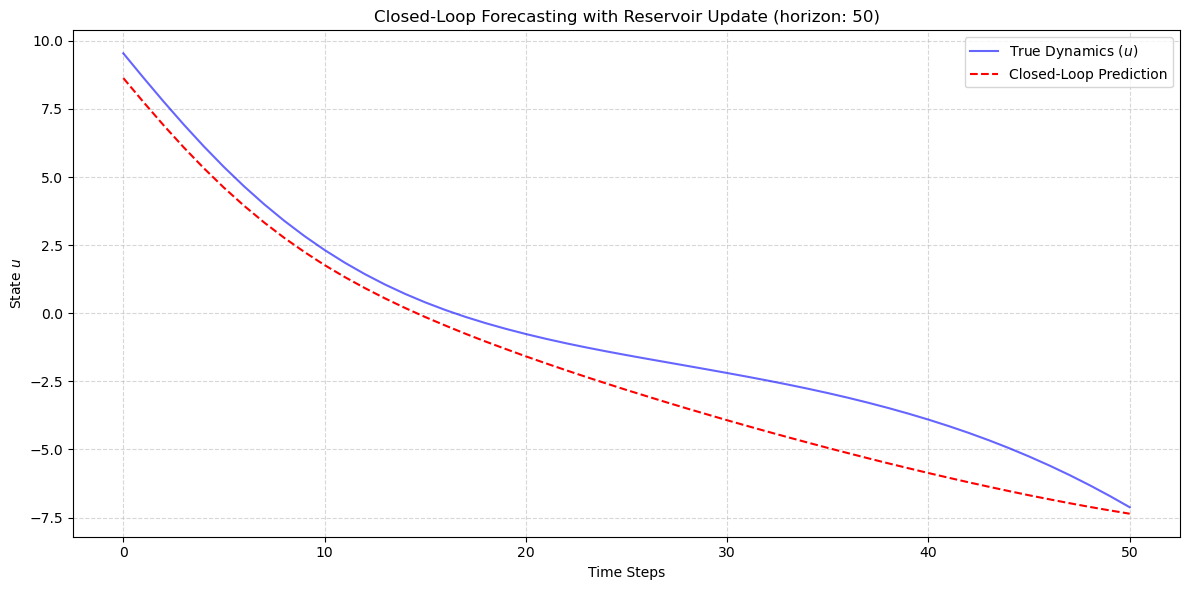

In [ ]:
print('2. Starting Closed-Loop Forecasting with Reservoir Update...')

horizon = 50  # 你想要預測多遠
x_curr = x_states[split]
x_full = poly.transform(x_curr.reshape(1, -1))
x_full_scaled = scaler.transform(x_full)

next_u = lasso_cv_full.predict(x_full_scaled)
predictions = []
predictions.append(next_u)

for t in range(horizon):
    u_pred = predictions[-1]
    x_next = A @ x_curr + C * u_pred

    x_next_reshaped = x_next.reshape(1, -1)
    x_full = poly.transform(x_next_reshaped)
    x_full_scaled = scaler.transform(x_full)

    next_u = lasso_cv_full.predict(x_full_scaled)

    predictions.append(next_u)
    x_curr = x_next
    
Y_pred_full= np.array(predictions).squeeze()
Y_test = u[split: split + len(predictions)]

mse_closed = np.mean((Y_test - Y_pred_full)**2)
print(f"Closed-Loop MSE: {mse_closed:.6f}")

# ======================================================
# 3. Visualization
# ======================================================

plt.figure(figsize=(12, 6))

plt.plot(np.arange(len(Y_test)), Y_test, 'b-', label='True Dynamics ($u$)', alpha=0.6)
plt.plot(np.arange(len(Y_pred_full)), Y_pred_full, 'r--', label='Closed-Loop Prediction', linewidth=1.5)

plt.title(f"Closed-Loop Forecasting with Reservoir Update (horizon: {horizon})")
plt.xlabel("Time Steps")
plt.ylabel("State $u$")
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('../images/closed_loop_full_forecast.png', dpi=300)